<a href="https://colab.research.google.com/github/danyarmarkin/llm-review-classification/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Инициализация

Скачиваем датасеты

In [ ]:
!git clone https://github.com/danyarmarkin/llm-review-classification.git

Устанавливаем необходимые библиотеки

In [ ]:
!pip install transformers datasets accelerate peft bitsandbytes scikit-learn pandas numpy torch sentencepiece

In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, pipeline, BitsAndBytesConfig,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, classification_report
import re
from tqdm.auto import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

Импорт датасетов

In [4]:
train_df = pd.read_csv('/content/llm-review-classification/task/train.csv')
test_df = pd.read_csv('/content/llm-review-classification/task/test.csv')

with open('/content/llm-review-classification/task/categories.txt', 'r', encoding='utf-8') as f:
    categories = [line.strip() for line in f.readlines()]

print(f"categories: {categories}")
print(f"train_df size: {len(train_df)}")
print(f"test_df size: {len(test_df)}")

categories: ['бытовая техника', 'обувь', 'одежда', 'посуда', 'текстиль', 'товары для детей', 'украшения и аксессуары', 'электроника', 'нет товара']
train_df size: 1818
test_df size: 7276


## Разметка и подготовка данных к обучению

Загружаем [Qwen/Qwen2-7B-Instruct](https://huggingface.co/Qwen/Qwen2-7B-Instruct) с 4-bit квантованием

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

model_name = "Qwen/Qwen2-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

### Разметка Датасета

Размечаем данный нам датасет при помощи промпта в загруженную модель. Используем few-shot стратегию.

In [6]:
def create_prompt(text, categories):
    prompt = f"""<|system|>
Ты — ассистент для точной классификации отзывов с маркетплейса. Твоя задача — определить категорию товара, к которому относится отзыв.

**Инструкции:**
1. Внимательно проанализируй текст отзыва.
2. Если отзыв НЕ о конкретном товаре (жалоба на доставку, службу поддержки, упаковку, скидки и т.д.) — ответь "нет товара".
3. Если отзыв о товаре, определи его категорию ТОЛЬКО из списка: {categories}.
4. Обращай особое внимание на контекст. Упоминание проблемы ("брак", "косяки") не всегда означает категорию.
5. Определи основной товар, о котором идет речь.

**Примеры правильной классификации:**
Отзыв: "Куртка отличная, но размер маловат. Пришлось обменять." -> Категория: Одежда
Отзыв: "Доставили на день позже обещанного, но товар целый." -> Категория: нет товара
Отзыв: "Книга интересная, но в мягком переплете, быстро порвалась." -> Категория: Книги
Отзыв: "Игрушка сломалась через день, очень расстроен." -> Категория: Товары для детей

**Отзыв для анализа:**
"{text}"

<|assistant|>
Категория:"""
    return prompt

def get_category(text, max_new_tokens=5):
    prompt = create_prompt(text, categories)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    category_line = response.lower().split("категория:")[-1]
    predicted_category = "нет товара"
    for cat in categories:
      if cat in category_line:
        predicted_category = cat
        break

    return predicted_category

train_sample = train_df.copy()

labeled_data = []
for i, row in tqdm(train_sample.iterrows(), total=len(train_sample)):
    try:
        category = get_category(row['text'])
        # print(category)
        labeled_data.append({'text': row['text'], 'category': category})
    except Exception as e:
        print(e)
        continue

labeled_df = pd.DataFrame(labeled_data)

valid_categories = set(categories)
labeled_df = labeled_df[labeled_df['category'].isin(valid_categories)]

labeled_df.to_csv("labeled_dataset.csv")

print(f"labeled {len(labeled_df)} items")
print(labeled_df['category'].value_counts())

  0%|          | 0/1818 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


labeled 1818 items
category
одежда              1141
нет товара           412
текстиль             209
обувь                 22
товары для детей      15
электроника           13
бытовая техника        4
посуда                 2
Name: count, dtype: int64


In [7]:
labeled_df = pd.read_csv('labeled_dataset.csv')

### Генерация синтетических данных

Видим, что некоторых категорий катастрофически мало. Значит, нужно генерировать синтетические данные. Для этого используем промпт в загруженную модель + будем валидировать отзывы этой же моделью. Для генерации отзывов ставим большую температуру, чтобы получать бОльшее разнообразие.

In [8]:
def generate_synthetic_reviews(category, n_samples):
    prompt_template = f"""<|system|>
Сгенерируй {n_samples} реалистичных отзывов на товары категории "{category}".

**Требования:**
1. Отзывы должны быть максимально естественными и разнообразными
2. Используй разговорный язык с естественными опечатками и сокращениями
3. Разный тон: негативные, восторженные, нейтральные, разочарованные, но конструктивные
4. Упоминай конкретные особенности товаров этой категории
5. Длина: от 1 до 3 предложений
6. Включай как оценку товара, так и личный опыт использования

**Пример хорошего отзыва:**
"Покупкой очень доволен, особенно ценой. Но качество, возможно, можно было бы улучшить. Рекомендую!"

<|assistant|>
Синтетические отзывы для категории "{category}":
1. """
    try:
        inputs = tokenizer(prompt_template, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2500,
                temperature=0.85,
                do_sample=True,
                top_p=0.9,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if "Синтетические отзывы" in response:
            reviews_text = response.split("Синтетические отзывы")[-1]
        else:
            reviews_text = response

        reviews = []
        lines = reviews_text.split('\n')

        for line in lines:
            line = line.strip()
            if re.match(r'^\d+\.', line):
                review_text = re.sub(r'^\d+\.\s*', '', line).replace("\"", "")
                if len(review_text) > 15:
                    reviews.append(review_text)
            elif len(line) > 30 and ':' not in line and not line.isdigit():
                reviews.append(line)

        return reviews[:n_samples]

    except Exception as e:
        print(e)
        return []

def validate_generated_review(review, target_category, validator_model, validator_tokenizer):
    validation_prompt = f"""<|system|>
Быстро проверь, относится ли этот отзыв к категории "{target_category}".
Отзыв: "{review}"
Ответь только "да" или "нет".

<|assistant|>"""

    try:
        inputs = validator_tokenizer(validation_prompt, return_tensors="pt").to(validator_model.device)

        with torch.no_grad():
            outputs = validator_model.generate(
                **inputs,
                max_new_tokens=3,
                temperature=0.1,
                do_sample=False
            )

        response = validator_tokenizer.decode(outputs[0], skip_special_tokens=True)
        return "да" in response.lower()

    except Exception as e:
        print(e)
        return False

print("start generating reviews...")

category_counts = labeled_df['category'].value_counts()
print("now:")
print(category_counts)

target_samples = 150
synthetic_data = []

for category in tqdm(categories):
    current_count = category_counts.get(category, 0)
    needed_samples = max(0, target_samples - current_count)

    if needed_samples > 0:
        print(f"generating {needed_samples} reviews for '{category}'...")

        batch_size = 8
        valid_reviews = []
        for _ in tqdm(range((needed_samples + batch_size - 1) // batch_size)):
          generated_reviews = generate_synthetic_reviews(category, batch_size)

          for review in generated_reviews:
              if validate_generated_review(review, category, model, tokenizer):
                  valid_reviews.append(review)

        for review in valid_reviews[:needed_samples]:
          synthetic_data.append({
              'text': review,
              'category': category
          })

        print(f"Added {len(valid_reviews[:needed_samples])} reviews for '{category}'")
        print()

synthetic_df = pd.DataFrame(synthetic_data)
print("=" * 20)
print(f"Generated {len(synthetic_df)} reviews")
synthetic_df.to_csv('enriched_training_data.csv', index=False, encoding='utf-8')

start generating reviews...
now:
category
одежда              1141
нет товара           412
текстиль             209
обувь                 22
товары для детей      15
электроника           13
бытовая техника        4
посуда                 2
Name: count, dtype: int64


  0%|          | 0/9 [00:00<?, ?it/s]

generating 146 reviews for 'бытовая техника'...


  0%|          | 0/19 [00:00<?, ?it/s]

Added 146 reviews for 'бытовая техника'

generating 128 reviews for 'обувь'...


  0%|          | 0/16 [00:00<?, ?it/s]

Added 128 reviews for 'обувь'

generating 148 reviews for 'посуда'...


  0%|          | 0/19 [00:00<?, ?it/s]

Added 148 reviews for 'посуда'

generating 135 reviews for 'товары для детей'...


  0%|          | 0/17 [00:00<?, ?it/s]

Added 135 reviews for 'товары для детей'

generating 150 reviews for 'украшения и аксессуары'...


  0%|          | 0/19 [00:00<?, ?it/s]

Added 150 reviews for 'украшения и аксессуары'

generating 137 reviews for 'электроника'...


  0%|          | 0/18 [00:00<?, ?it/s]

Added 137 reviews for 'электроника'

Generated 844 reviews


Объединяем размеченный датасет и синтетический в один финальный

In [9]:
final_training_df = pd.concat([labeled_df, synthetic_df], ignore_index=True)
final_training_df['category'].value_counts()

,count
category,
одежда,1141
нет товара,412
текстиль,209
электроника,150
товары для детей,150
обувь,150
посуда,150
бытовая техника,150
украшения и аксессуары,150


## Fine-Tuning

Для дообучения выбрана модель [cointegrated/LaBSE-en-ru](https://huggingface.co/cointegrated/LaBSE-en-ru)

Делим датасет для обучения и валидации при помощи `train_test_split` и прогоняем его через токенизатор модели

Так же меняем категории на числа

In [10]:

label2id = {label: i for i, label in enumerate(categories)}
id2label = {i: label for i, label in enumerate(categories)}

import json
with open('label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({'label2id': label2id, 'id2label': id2label}, f, ensure_ascii=False)

classifier_model_name = "cointegrated/LaBSE-en-ru"
classifier_tokenizer = AutoTokenizer.from_pretrained(classifier_model_name)

def tokenize_function(examples):
    return classifier_tokenizer(
        examples["text"],
        padding=False,
        truncation=True,
        max_length=256
    )

dataset = Dataset.from_pandas(final_training_df)
dataset = dataset.train_test_split(test_size=0.2, seed=239)

tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

def add_labels(examples):
    examples["label"] = [label2id[cat] for cat in examples["category"]]
    return examples

tokenized_datasets = tokenized_datasets.map(add_labels, batched=True)

data_collator = DataCollatorWithPadding(
    tokenizer=classifier_tokenizer,
    padding=True
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/2129 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

Map:   0%|          | 0/2129 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

Загружаем модель и при помощи конфига `LoRA` начинаем дообучение

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    classifier_model_name,
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "value"],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=classifier_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.save_model("best_model")
classifier_tokenizer.save_pretrained("best_model")

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/LaBSE-en-ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 596,745 || all params: 128,948,754 || trainable%: 0.4628


Epoch,Training Loss,Validation Loss,F1
1,0.783700,0.787815,0.788973
2,0.529400,0.533533,0.831288
3,0.441400,0.480496,0.838497
4,0.367100,0.479389,0.845326
5,0.282300,0.466487,0.849597


('best_model/tokenizer_config.json',
 'best_model/special_tokens_map.json',
 'best_model/vocab.txt',
 'best_model/added_tokens.json',
 'best_model/tokenizer.json')

### Оценка качества модели

Фиксируем показания лучшей модели на валидирующем датасете

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./best_model",
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id
)

classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=classifier_tokenizer,
    device=model.device.index if torch.cuda.is_available() else -1
)

def predict(text):
    result = classifier(text, truncation=True, max_length=256)
    return result[0]['label']

val_df = dataset["test"].to_pandas()
val_texts = val_df["text"].tolist()
val_true = val_df["category"].tolist()

val_pred = []
for text in tqdm(val_texts):
    val_pred.append(predict(text))

print(classification_report(val_true, val_pred, target_names=categories))
print(f"Weighted F1: {f1_score(val_true, val_pred, average='weighted')}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/LaBSE-en-ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


  0%|          | 0/533 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                        precision    recall  f1-score   support

       бытовая техника       0.85      0.85      0.85        33
                 обувь       0.86      0.89      0.88        79
                одежда       0.89      0.89      0.89        27
                посуда       0.86      0.91      0.88       235
              текстиль       0.93      0.79      0.85        33
      товары для детей       0.48      0.36      0.41        36
украшения и аксессуары       0.96      0.84      0.90        32
           электроника       0.92      0.92      0.92        26
            нет товара       0.88      0.88      0.88        32

              accuracy                           0.85       533
             macro avg       0.85      0.81      0.83       533
          weighted avg       0.85      0.85      0.85       533

Weighted F1: 0.8495968125660693


## Предсказание и замер скорости работы


Размечаем тестовый датасет при помощи дообученной модели. Замеряем скорость работы.

  0%|          | 0/7276 [00:00<?, ?it/s]

avg time: 0.0129 seconds
max time: 0.0302 seconds


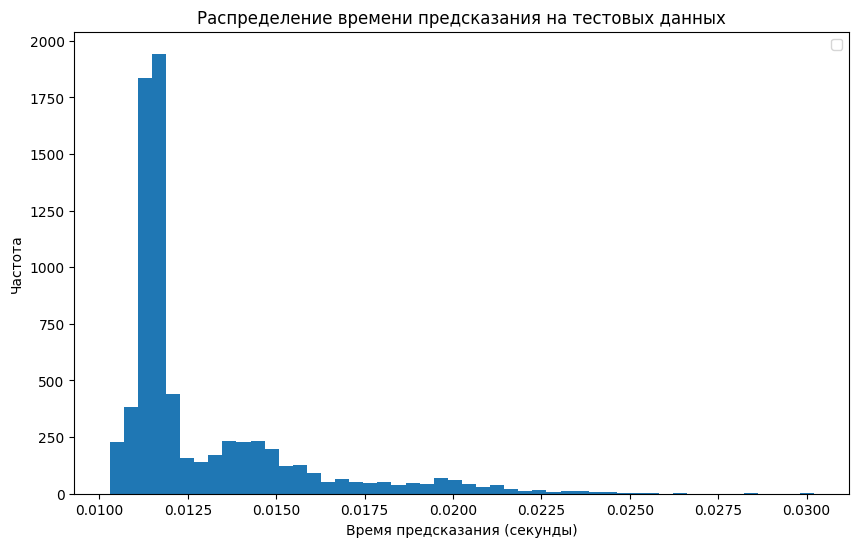

In [14]:
test_texts = test_df["text"].tolist()

test_predictions = []
inference_times = []

for text in tqdm(test_texts):
    start_time = time.time()
    pred = predict(text)
    end_time = time.time()

    test_predictions.append(pred)
    inference_times.append(end_time - start_time)

test_df['category'] = test_predictions

test_df.to_csv('prediction.csv', index=False)
test_df = test_df['category']
test_df.to_csv("submission.csv", index=False)

avg_inference_time = np.mean(inference_times)
max_inference_time = np.max(inference_times)

print(f"avg time: {avg_inference_time:.4f} seconds")
print(f"max time: {max_inference_time:.4f} seconds")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(inference_times, bins=50)
plt.xlabel('Время предсказания (секунды)')
plt.ylabel('Частота')
plt.title('Распределение времени предсказания на тестовых данных')
plt.legend()
plt.show()